# Demo notebook: 
## Facial landmarking - Active Appearance Model


## Configuration

In [1]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'


# webcam: int
#     An integer indicating the number of the webcam to be used. If there is just
#     one webcam, this will usually be 0.
webcam = 0


# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True


# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

## Preparations

An auxiliary function to check for an install packages if missing:

In [2]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Requirements

To run all of this notebook, you need the following libraries to be installed:
* ImageIO (`imageio` and `imageio-ffmpeg`): for reading images and accessing the webcam
* MatPlotLib (`matplotlib`): mainly for displaying images in the notebook
* Menpo (`menpo`): for the AAM structures
* Menpodetect (`menpodetect`): provides the Dlib face detector
* Menpofit (`menpofit`): providing the shape fitter

Running the following cell will create a file `demo.yml` that can be used to setup a conda environment containing the required packages. 

In [16]:
%%writefile aam_demo.yml
name: aam_demo
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6 #ran into troubles with python3.8
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - menpo
  - menpodetect
  - menpofit

Overwriting aam_demo.yml


To create the environment, open a shell and type
```sh
conda env create -f demo.yml
```
Remember that after running this command you have to activate the environment (Linux/MacOS: `conda activate demo`, Windows: `activate demo`) and then start jupyter in that environment.

# /images
Please make sure you also downloaded the folder images along with its content and stored it in the same directory as this notebook.

# Active Appearance Model



## Dataset:
The pretrained model used in this demo was trained on multiple Datasets:
LFPW trainset, HELEN trainset, IBUG and AFW datasets which are hosted in http://ibug.doc.ic.ac.uk/resources/facial-point-annotations/.

The (in total) 3283 images contain 68 landmarks that were labeled manually.

## Package (Menpo)

My personal experience with this package was very clunky.
* Input requires importing from file.
* Conversion from e.g. numpy array not possible
* Menpo image = each pixel has channels for additional information



## Demo - Image

In [3]:
import imageio
import matplotlib.pyplot as plt
import menpo.io as mio
from menpodetect import load_dlib_frontal_face_detector
from menpofit.aam import load_balanced_frontal_face_fitter

In [4]:
# Load detector (dlib)
detector = load_dlib_frontal_face_detector()

# Load pretrained fitter
fitter = load_balanced_frontal_face_fitter()

1 detected faces.


/Users/til/opt/anaconda3/envs/aam_demo/lib/python3.6/site-packages/menpofit/visualize/base.py:389: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(subplots[0], subplots[1], k + 1)


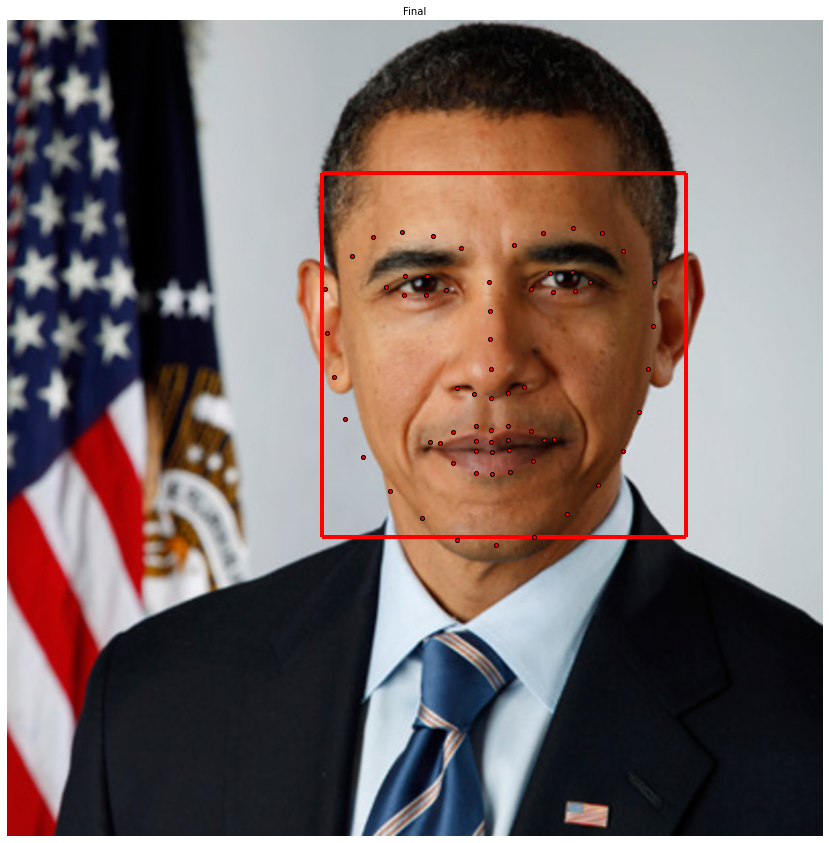

In [51]:

# import an image from your images folder as a menpo object
image = mio.import_image('images/obama.jpg')

# a greyscaled version is required for the facedetection/fitting
image_grey = image.as_greyscale()


# Detect faces in image = bounding box
faces = detector(image_grey)
if len(faces) == 0:
    print('No face detected')
    raise StopExecution
else:
    print("{} detected faces.".format(len(faces)))


# fit mapping on imported image
# The bounding box is used in order to align the model's reference shape as first "guess" 
result = fitter.fit_from_bb(image, faces[0], max_iters=(15,0))



# visualize the detected face ...
if len(faces) > 0:
    image_grey.view_landmarks(group='dlib_0', line_colour='red',
                         render_markers=False, line_width=4);
# ... and the fitted landmarks on top of the original (colored image)
result.view(render_initial_shape=False,figure_size=(15,15))

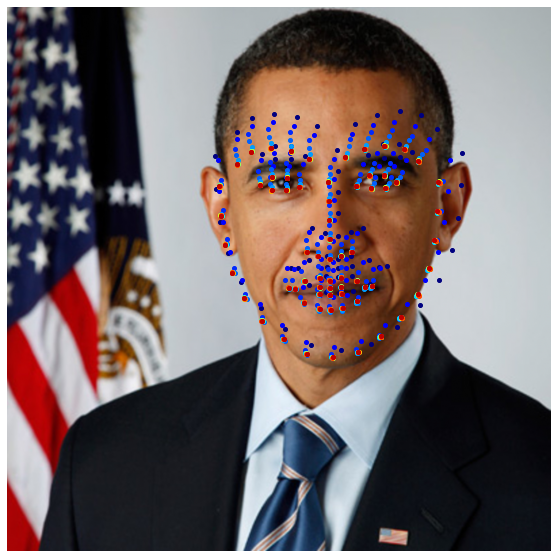

In [59]:
# Additionally the iterations of the fitting process can be visualized

result.view_iterations(figure_size=(10,10),render_legend=False)


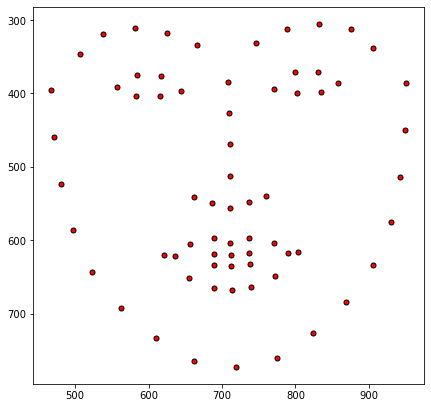

In [62]:
# Or the final shape by itself
result.final_shape.view()

## Demo - Selfie

In [48]:
# (in case tools were not imported before)

import imageio
import matplotlib.pyplot as plt
import menpo.io as mio
from menpodetect import load_dlib_frontal_face_detector
from menpofit.aam import load_balanced_frontal_face_fitter

# Load detector (dlib)
detector = load_dlib_frontal_face_detector()

# Load pretrained fitter
fitter = load_balanced_frontal_face_fitter()



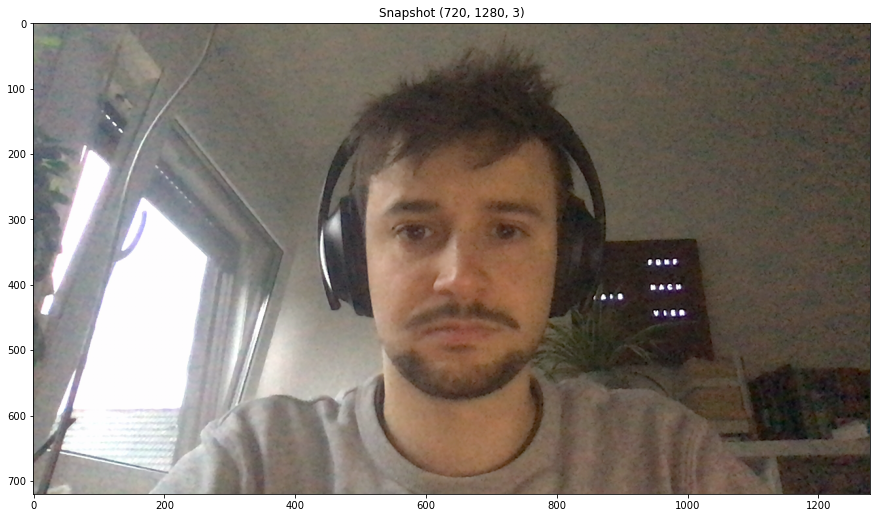

In [20]:
camera = None
image = None

# open camera, take picture and close camera after
try:
    camera = imageio.get_reader(f'<video{webcam}>')
    image = camera.get_next_data()
finally:
    if camera is not None:
        camera.close()

# display picture taken        
if image is not None:
    plt.figure(figsize=(15,15))
    plt.title(f"Snapshot {image.shape}")
    plt.imshow(image)
    plt.show()

# save image to current dir in folder images
imageio.imwrite('images/webcam.jpg', image)



1 detected faces.


/Users/til/opt/anaconda3/envs/aam_demo/lib/python3.6/site-packages/menpofit/visualize/base.py:389: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(subplots[0], subplots[1], k + 1)


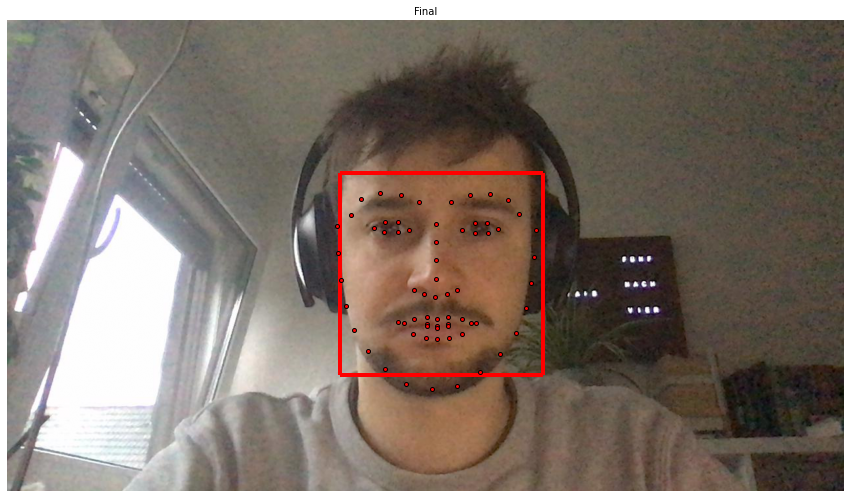

In [21]:
# load previously recorded image and convert to greyscale
image_cam = mio.import_image('images/webcam.jpg')
image_grey = image_cam.as_greyscale()


# Detect faces in image
faces = detector(image_grey)
if len(faces) == 0:
    print('No face detected')
    raise StopExecution
else:
    print("{} detected faces.".format(len(faces)))


# fit mapping on recorded image
result = fitter.fit_from_bb(image_cam, faces[0], max_iters=(20,5))


# visualize the detected face ...
if len(faces) > 0:
    image_grey.view_landmarks(group='dlib_0', line_colour='red',
                         render_markers=False, line_width=4);
# ... and the fitted landmarks on top of the original (colored image)
result.view(render_initial_shape=False,figure_size=(15,15))


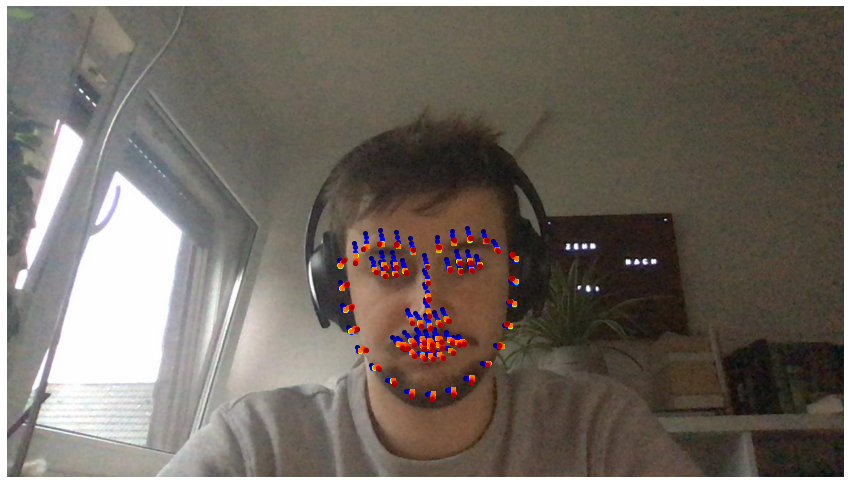

In [11]:
# Additionally the iterations of the fitting process can be visualized
result.view_iterations(figure_size=(15,15),render_legend=False)